In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('Wine1kopya.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df



<ipython-input-1-f20a35df4061>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)


In [3]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]


In [4]:
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled


In [5]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]


In [6]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model


In [7]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]


In [8]:
# load dataset
series = read_csv('Wine1kopya.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)


In [9]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)


In [10]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values


In [11]:
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]


In [12]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)


In [13]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)


array([[-0.7069843 ],
       [ 0.01427811],
       [-0.5016262 ],
       [ 0.21914358],
       [-0.19252852],
       [ 0.23705654],
       [-0.40659082],
       [-0.1625359 ],
       [ 0.02067992],
       [ 0.67724204],
       [-0.9631232 ],
       [-0.05765558],
       [-0.31856486],
       [ 0.10945687],
       [-0.284693  ],
       [-0.4490918 ],
       [ 0.5580522 ],
       [-0.14097694],
       [ 0.36901397],
       [-0.33785623],
       [ 0.25317127],
       [-0.8627504 ],
       [ 0.34615165]], dtype=float32)

In [14]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=1, Predicted=352.703661, Expected=339.700000
Month=2, Predicted=277.599043, Expected=440.400000
Month=3, Predicted=270.404526, Expected=315.900000
Month=4, Predicted=381.237169, Expected=439.300000
Month=5, Predicted=390.148275, Expected=401.300000
Month=6, Predicted=374.139316, Expected=437.400000
Month=7, Predicted=368.270041, Expected=575.500000
Month=8, Predicted=363.109007, Expected=407.600000
Month=9, Predicted=385.666170, Expected=682.000000
Month=10, Predicted=489.918629, Expected=475.300000
Month=11, Predicted=252.011668, Expected=581.300000
Month=12, Predicted=415.898676, Expected=646.900000


Test RMSE: 166.078


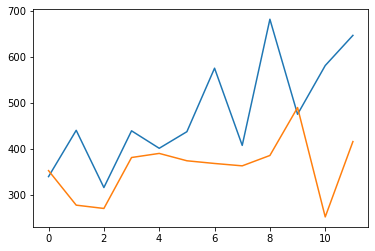

In [16]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()